In [1]:
import os
import cv2
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns

from src.preprocess import *

In [2]:
# Step 0: Data Preparation
train_df = pd.read_csv('data/train_df.csv', usecols=['image_path', 'Target'])
train_df['Target'] = train_df['Target'].str.strip()
train_df['image_path'] = train_df['image_path'].apply(lambda x: os.path.join("data", x.lstrip("./")))

In [3]:
# Fix multi-labels
multi_labels = [i for i, target in enumerate(train_df['Target']) if len(target) > 2]
corrected_labels = []
for ml in multi_labels:
    corrected_labels.append([train_df.loc[ml, 'image_path'], train_df.loc[ml, 'Target'].split(' ')[0]])
train_df = pd.concat([train_df.drop(train_df.loc[multi_labels].index),
                      pd.DataFrame(corrected_labels, columns=['image_path', 'Target'])],
                     ignore_index=True)

In [4]:
# Stratified Split: Train, Validation, Test
trainval_df, test_df = train_test_split(train_df, test_size=0.15, random_state=42, stratify=train_df['Target'])
train_df_final, val_df = train_test_split(trainval_df, test_size=0.1765, random_state=42, stratify=trainval_df['Target'])

In [5]:
# Step 1: Dataset Class
class XrayDataset(Dataset):
    def __init__(self, dataframe):
        self.df = dataframe
    def __len__(self):
        return len(self.df)
    def __getitem__(self, idx):
        img_path = self.df.iloc[idx]['image_path']
        label = int(self.df.iloc[idx]['Target'])
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        if img is None:
            raise FileNotFoundError(f"Image not found: {img_path}")
        img_tensor = pre_processing(img)
        return img_tensor, label

train_loader = DataLoader(XrayDataset(train_df_final), batch_size=32, shuffle=True)
val_loader = DataLoader(XrayDataset(val_df), batch_size=32, shuffle=False)
test_loader = DataLoader(XrayDataset(test_df), batch_size=32, shuffle=False)


In [ ]:
# Step 2: CNN Model Definition
class CNNClassifier(nn.Module):
    def __init__(self, num_classes=16):
        super(CNNClassifier, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.avgpool = nn.AdaptiveAvgPool2d((7, 7))
        self.fc1 = nn.Linear(64 * 7 * 7, 128)
        self.fc2 = nn.Linear(128, num_classes)
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [7]:
# Step 3: Training Setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_classes = train_df["Target"].nunique()
model = CNNClassifier(num_classes=num_classes).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)

In [ ]:
# Step 4: Training Loop
epochs = 10
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    correct_predictions = 0
    total_samples = 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device).long()
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        correct_predictions += (preds == labels).sum().item()
        total_samples += labels.size(0)

    avg_loss = running_loss / len(train_loader)
    accuracy = 100 * correct_predictions / total_samples

    model.eval()
    val_running_loss = 0.0
    val_correct = 0
    val_total = 0
    with torch.no_grad():
        for val_images, val_labels in val_loader:
            val_images, val_labels = val_images.to(device), val_labels.to(device).long()
            val_outputs = model(val_images)
            val_loss = criterion(val_outputs, val_labels)
            val_running_loss += val_loss.item()
            _, val_preds = torch.max(val_outputs, 1)
            val_correct += (val_preds == val_labels).sum().item()
            val_total += val_labels.size(0)

    val_avg_loss = val_running_loss / len(val_loader)
    val_accuracy = 100 * val_correct / val_total

    train_losses.append(avg_loss)
    val_losses.append(val_avg_loss)
    train_accuracies.append(accuracy)
    val_accuracies.append(val_accuracy)

    print(f"Epoch [{epoch+1}/{epochs}] - Train Loss: {avg_loss:.4f}, Train Accuracy: {accuracy:.2f}% - Val Loss: {val_avg_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%")

Epoch [1/5] - Train Loss: 2.4310, Train Accuracy: 41.12% - Val Loss: 2.2205, Val Accuracy: 41.76%
Epoch [2/5] - Train Loss: 2.2102, Train Accuracy: 42.11% - Val Loss: 2.1468, Val Accuracy: 41.76%
Epoch [3/5] - Train Loss: 2.1314, Train Accuracy: 42.60% - Val Loss: 2.0349, Val Accuracy: 43.30%
Epoch [4/5] - Train Loss: 1.9855, Train Accuracy: 44.16% - Val Loss: 1.9673, Val Accuracy: 45.59%
Epoch [5/5] - Train Loss: 1.8777, Train Accuracy: 46.96% - Val Loss: 1.8176, Val Accuracy: 45.98%


In [9]:
# Save the trained model
# torch.save(model.state_dict(), "xray_model.pth")

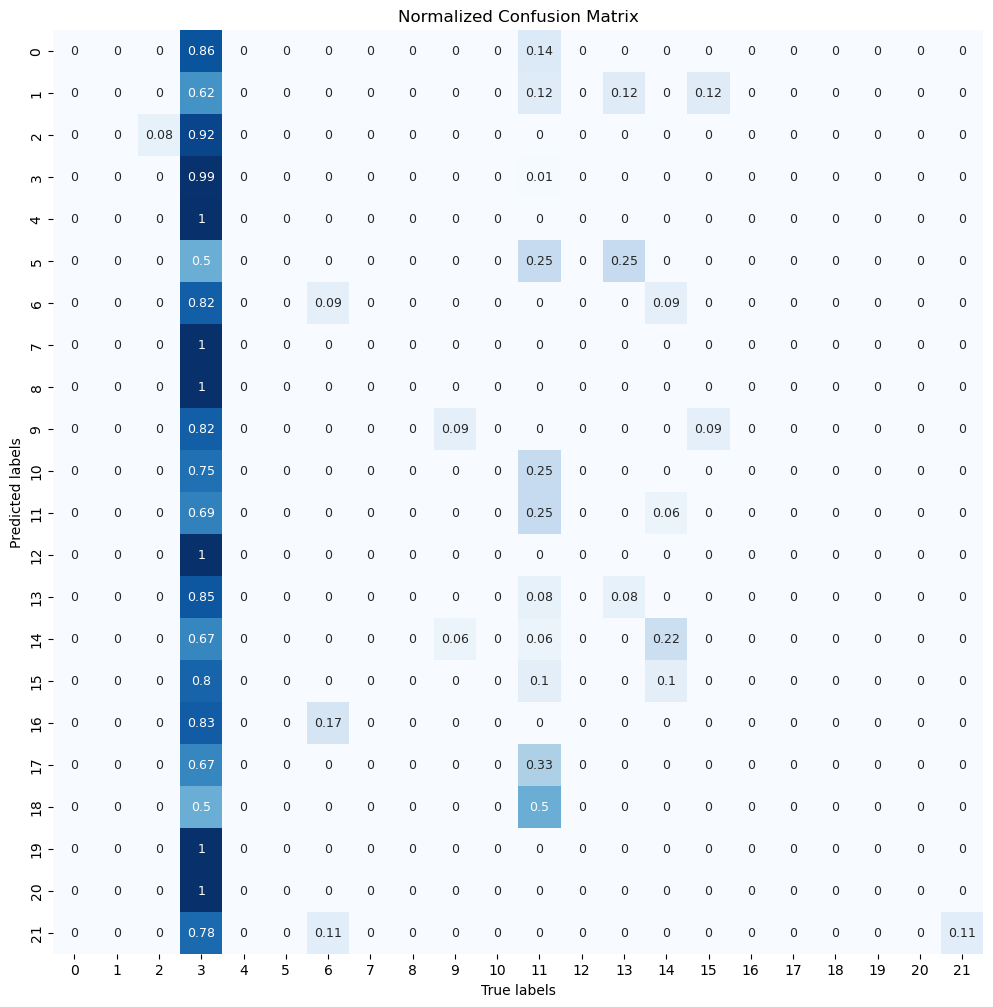

In [10]:
# Step 5: Confusion Matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

ture_labels = []
pred_labels = []
model.eval()
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device).long()
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        ture_labels.extend(labels.cpu().numpy())
        pred_labels.extend(preds.cpu().numpy())

conf_metric = confusion_matrix(ture_labels, pred_labels)
conf_metric_normalized = conf_metric / np.sum(conf_metric, axis=1, keepdims=True)

plt.figure(figsize=[12,12], dpi=100)
sns.heatmap(np.round(conf_metric_normalized, 2), cbar=False, annot=True, annot_kws={"size":9}, cmap=plt.cm.Blues)
plt.xlabel('True labels')
plt.ylabel('Predicted labels')
plt.title('Normalized Confusion Matrix')
plt.show()

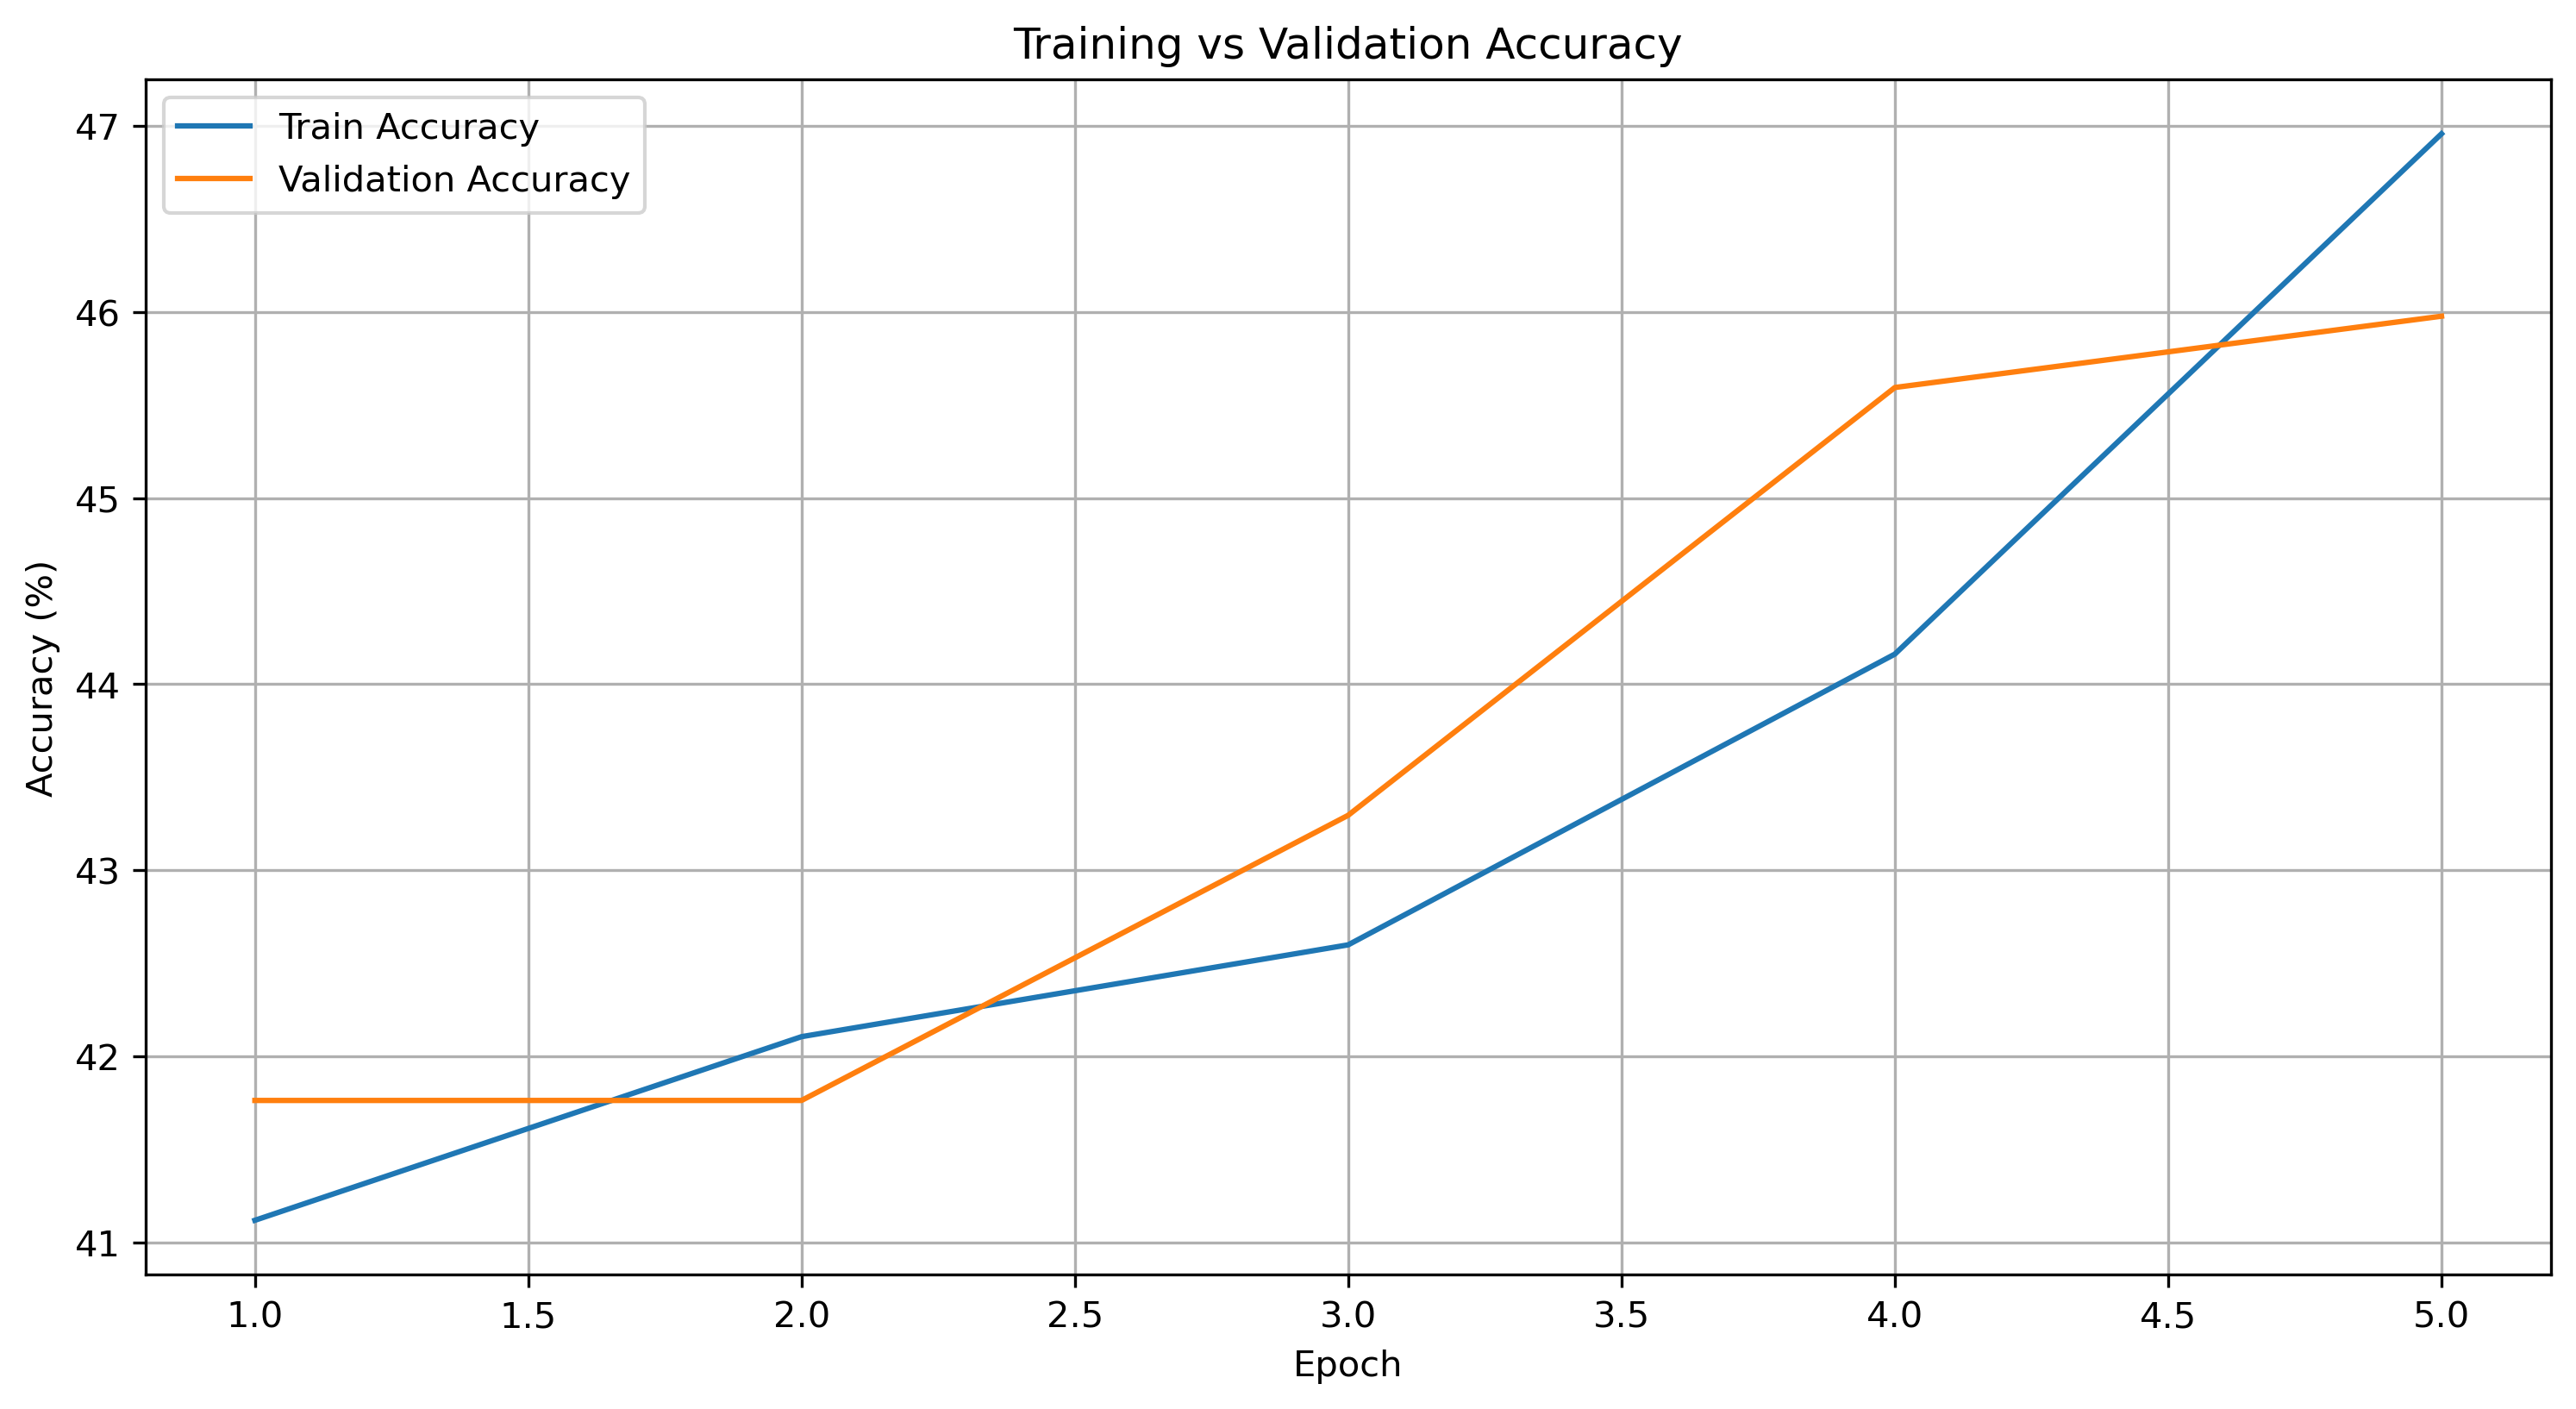

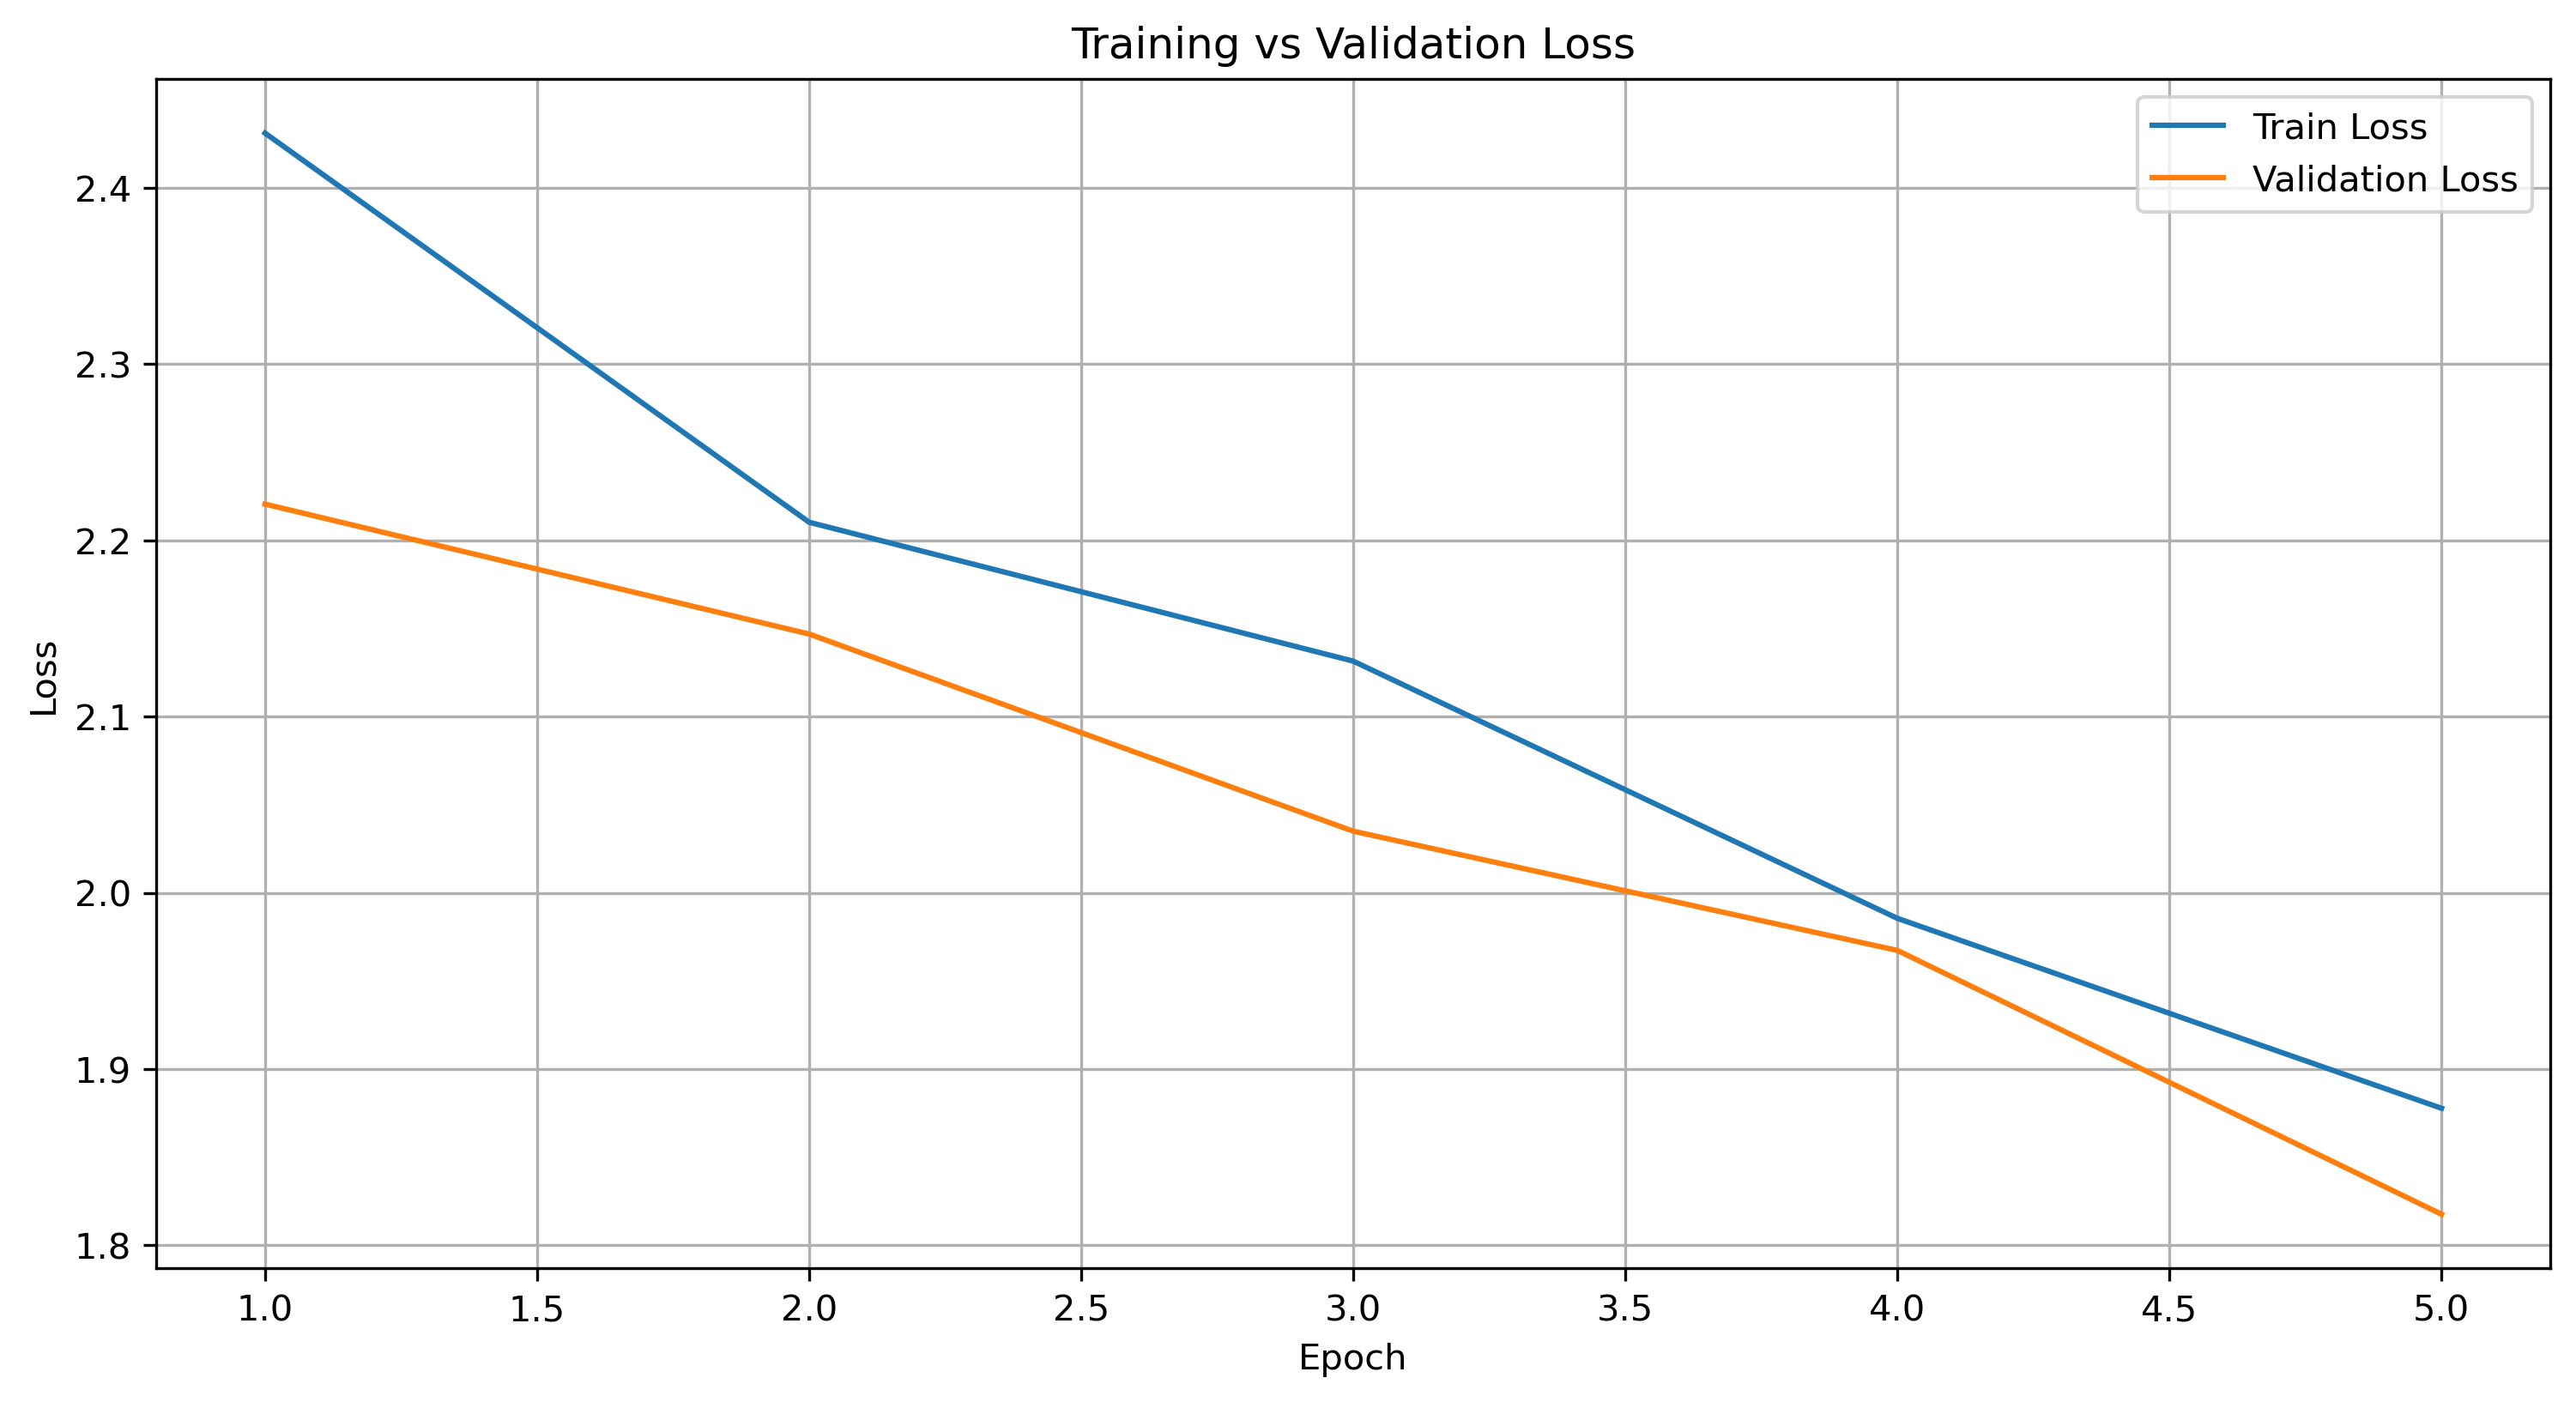

In [11]:
# Step 6: Accuracy and Loss Plots
plt.figure(figsize=[12,6], dpi=300)
sns.lineplot(x=list(range(1, epochs+1)), y=train_accuracies, label='Train Accuracy')
sns.lineplot(x=list(range(1, epochs+1)), y=val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Training vs Validation Accuracy')
plt.legend()
plt.grid()
plt.show()

plt.figure(figsize=[12,6], dpi=300)
sns.lineplot(x=list(range(1, epochs+1)), y=train_losses, label='Train Loss')
sns.lineplot(x=list(range(1, epochs+1)), y=val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.legend()
plt.grid()
plt.show()